In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import Levenshtein
from PIL import Image, ImageDraw

from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.ai.vision.imageanalysis import ImageAnalysisClient
from azure.ai.vision.imageanalysis.models import VisualFeatures
from azure.core.credentials import AzureKeyCredential
from msrest.authentication import CognitiveServicesCredentials


In [2]:
'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = "ad2b1d8267384aceb2f04586adf2723e"
endpoint = "https://cosminandrei-ai.cognitiveservices.azure.com//"
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))
cv_client = ImageAnalysisClient(endpoint=endpoint, credential=AzureKeyCredential(subscription_key))
'''
END - Authenticate
'''

'\nEND - Authenticate\n'

In [6]:
def proccess_image(img):
    read_response = computervision_client.read_in_stream(
        image=img,
        mode="Printed",
        raw=True
    )

    operation_id = read_response.headers['Operation-Location'].split('/')[-1]
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status not in ['notStarted', 'running']:
            break
        time.sleep(1)

    # Print the detected text, line by line
    result = []
    if read_result.status == OperationStatusCodes.succeeded:
        for text_result in read_result.analyze_result.read_results:
            for line in text_result.lines:
                result.append(line.text)

    return result

text = "Ana are mere și pere Anei nu îi plac merele, dar adoră ciocolata."
result = proccess_image(open("img2.jpeg", "rb"))
result_words = ' '.join(result)
print(result_words)

Ana are mere di pere Anei nu li plac merele, dar adora ciocolata.


In [7]:
# 1a - Levenshtein Distance - masoara numarul minim de operatii (inserare, stergere, substituire) pentru a transforma
# un sir de caractere in altul
def verify_levenshtein(result, text):
    char_dist = Levenshtein.distance(text, result)

    words = text.split()
    result_words = result.split()

    # da
    word_dist = Levenshtein.distance(words, result_words)

    return char_dist, word_dist

char_dist, word_dist = verify_levenshtein(result_words, text)
print("Distanta la nivel de caracter:", char_dist)
print("Distanta la nivel de cuvant:", word_dist)

Distanta la nivel de caracter: 3
Distanta la nivel de cuvant: 3


In [8]:
# 1b - varianta 1: jaccard - masoara similaritatea
# compara seturile de cuvinte, se compara la nivel de cuvant
def verify_jaccard(text, result):
    char_dist, word_dist = verify_levenshtein(result, text)

    # inversul proportiei de dist la nivel de cuvant
    # fata de len text real si text AI
    similarity = 1 - (word_dist / max(len(text), len(result)))

    return similarity

jaccard = verify_jaccard(text, result_words)
print("Similitudinea Jaccard: ", jaccard)

Similitudinea Jaccard:  0.9538461538461538


In [9]:
# 1b - varianta 2: hamming
def verify_hamming(text, result):
    if len(text) != len(result):
        print("Trebuie sa aiba aceeasi lungime")
        print("Lungime text: ", len(text))
        print("Lungime result: ", len(result))
        return None
    else:
        count = 0
        for i in range(len(text)):
            if text[i] != result[i]:
                count += 1
        return count
    
hamming = verify_hamming(text, result_words)
print("Similitudinea Hamming: ", hamming)

Similitudinea Hamming:  3


In [10]:
def string_to_ascii(s):
    return np.array([ord(c) for c in s])


# 1b - varianta 3: Distanta euclediana
def verify_euclidean(text, result):
    text_ascii = string_to_ascii(text)
    result_ascii = string_to_ascii(result)

    if len(text_ascii) != len(result_ascii):
        print("Trebuie sa aiba aceeasi lungime")
        print("Lungime text: ", len(text))
        print("Lungime result: ", len(result))
        return None
    else:
        diff = np.sum((text_ascii - result_ascii) ** 2)  # diferenta elementelor patrat si suma lor
        dist = np.sqrt(diff)
        return dist
    
euclidean = verify_euclidean(text, result_words)
# euclidean = verify_euclidean("ana", "ane")
print("Similitudinea Euclidean: ", euclidean)

Similitudinea Euclidean:  483.8522501756089


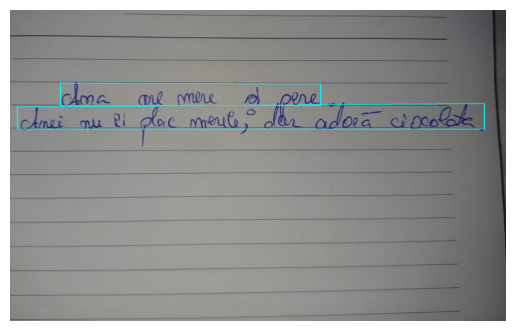

In [11]:
# 2 - calitatea localizarii corecte a textului in imagine
def quality_check(image_file):
    with open(image_file, 'rb') as image:
        image_data = image.read()

    image = open(image_file, 'rb')

    # Use Analyze image function to read text in image
    result = cv_client.analyze(
        image_data=image_data,
        visual_features=[VisualFeatures.READ]
    )

    if result.read is not None:
        image = Image.open(image_file)
        plt.axis('off')
        draw = ImageDraw.Draw(image)
        color = 'cyan'

        for line in result.read.blocks[0].lines:
            draw_line_polygon = True
            r = line.bounding_polygon
            bounding_polygon = ((r[0].x, r[0].y), (r[1].x, r[1].y), (r[2].x, r[2].y), (r[3].x, r[3].y))
            if draw_line_polygon:
                draw.polygon(bounding_polygon, outline=color, width=3)

    plt.imshow(image)
    plt.show()
    
quality_check("img2.jpeg")

In [12]:
# 3 - imbunatatirea procesului
# https://cs.stackexchange.com/questions/115462/difference-between-image-analysis-and-computer-vision#:~:text=Computer%20Vision%20though%2C%20is%20a,but%20with%20no%20clear%20boundaries.
# Computer Vision though, is a branch of AI, that is much different from the other two fields, since it focuses
# on learning, making inferences and taking actions based on visual inputs. Image Analysis (a.k.a Image
# Understanding) is between Image Processing and Computer Vision, but with no clear boundaries

# While there is significant overlap between the two fields, the main difference lies in their emphasis and
# scope. Computer Vision is more concerned with high-level understanding and interpretation of visual data to
# enable machines to perceive and interact with the world, while Image Analysis focuses on extracting detailed
# information and features from images for various analytical purposes.

# The low-level processes consume and produce images (e.g noise reduction, contrast enhancement,
# image sharpening), the mid-level processes take images and output attributes (e.g edges, contours,
# object identities).

def proccess_image_better(image_file):
    with open(image_file, 'rb') as image:
        image_data = image.read()

    # Use Analyze image function to read text in image
    result = cv_client.analyze(
        image_data=image_data,
        visual_features=[VisualFeatures.READ]
    )

    if result.read is not None:
        text = ""
        for line in result.read.blocks[0].lines:
            text += line.text + "\n"

        return text

    else:
        return None
    
result2 = proccess_image_better("img2.jpeg")
print(result2)

Ana are mere di pere
Anei nu li plac merece; dar adorà ciocolata.
